# Custom variables

## Setup the environment

In [1]:
import at
import at.plot
import sys
import numpy as np
from pathlib import Path
if sys.version_info.minor < 9:
    from importlib_resources import files, as_file
else:
    from importlib.resources import files, as_file

## Load a test lattice

In [4]:
fname = 'hmba.mat'
with as_file(files('machine_data') / fname) as path:
    hmba_lattice = at.load_lattice(path)

## Prepare a custom variable

Define a variable coupling two drift lengths so that their sum is constant:

In [5]:
class ElementShifter(at.Variable):
    def __init__(self, ring, ref1, ref2, total_length=None, **kwargs):
        """Varies the length of the elements identified by *ref1* and *ref2*
        keeping the sum of their lengths equal to *total_length*.

        If *total_length* is None, it is set to the initial total length
        """        
        # store indexes of the 2 variable elements
        self.ref1 = ring.get_uint32_index(ref1)[0]
        self.ref2 = ring.get_uint32_index(ref2)[0]
        # store the initial total length
        if total_length is None:
            total_length = ring[self.ref1].Length + ring[self.ref2].Length
        self.length = total_length
        super().__init__(self.setfun, self.getfun,
                         refpts=[self.ref1, self.ref2],
                         bounds=(0.0, total_length), **kwargs)

    def setfun(self, ring, value):
        ring[self.ref1].Length = value
        ring[self.ref2].Length = self.length - value

    def getfun(self, ring):
        return  ring[self.ref1].Length

Create a variable moving the monitor `BPM_01`

In [6]:
var2 = ElementShifter(hmba_lattice, "DR_01", "DR_02", name='DR_01')

Create a constraint {math}`\beta_y=3.0` on `BPM_01`

In [7]:
obs2 = at.LocalOpticsObservable('BPM_01', 'beta', plane='v', target=3.0)

## Run the matching

In [8]:
variables = at.VariableList([var2])
constraints = at.ObservableList(hmba_lattice, [obs2])
newring = at.match(hmba_lattice, variables , constraints, verbose=1)


1 constraints, 1 variables, using method trf

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.6515e+00, final cost 7.1885e-27, first-order optimality 8.52e-14.

Constraints:

location              Initial            Actual         Low bound        High bound          residual 
beta[y]
    BPM_01                5.30283               3.0               3.0               3.0       1.19332e-16 

Variables:

        Name      Initial          Final        Variation

       DR_01    2.651400e+00    9.693778e-01   -1.682022e+00


In [9]:
for elem in newring.select([2,3,4]):
    print(elem)

Drift:
	FamName : DR_01
	Length : 0.9693778252605573
	PassMethod : DriftPass
Monitor:
	FamName : BPM_01
	Length : 0.0
	PassMethod : IdentityPass
	Offset : [0 0]
	Scale : [1 1]
	Reading : [0 0]
	Rotation : [0 0]
Drift:
	FamName : DR_02
	Length : 1.7245741747394425
	PassMethod : DriftPass


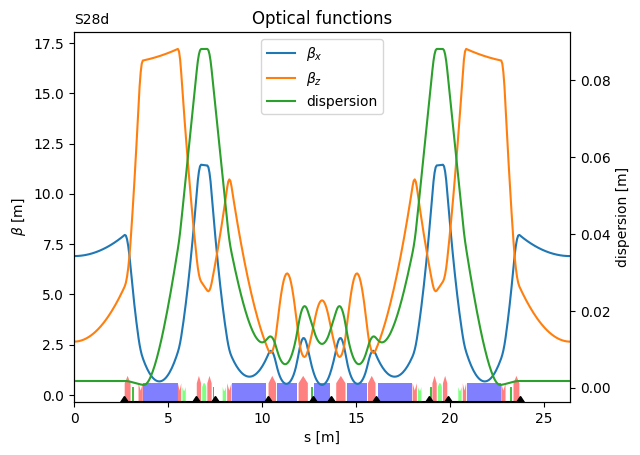

(<Axes: title={'left': 'S28d', 'center': 'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <Axes: ylabel='dispersion [m]'>,
 <Axes: >)

In [10]:
hmba_lattice.plot_beta()

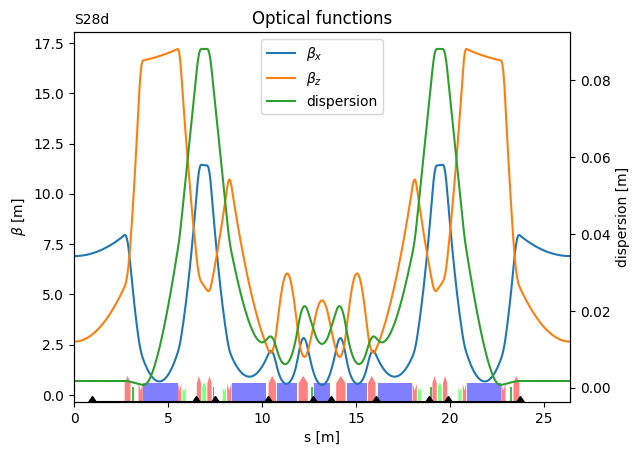

(<Axes: title={'left': 'S28d', 'center': 'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <Axes: ylabel='dispersion [m]'>,
 <Axes: >)

In [11]:
newring.plot_beta()